In [ ]:

import os
import json
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

warnings.filterwarnings('ignore')


In [3]:
data = '/kaggle/input/fashion-product-images-dataset/fashion-dataset'
os.listdir(data)

['images.csv', 'images', 'styles.csv', 'styles', 'fashion-dataset']

In [4]:
styles_df=pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv',on_bad_lines='skip')
images_df = pd.read_csv(data + '/images.csv', on_bad_lines="skip")


In [5]:
styles_df['image'] = styles_df.apply(lambda row: os.path.join(data, 'images', str(row['id']) + ".jpg"), axis=1)
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/kaggle/input/fashion-product-images-dataset/f...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/kaggle/input/fashion-product-images-dataset/f...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,/kaggle/input/fashion-product-images-dataset/f...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/kaggle/input/fashion-product-images-dataset/f...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/kaggle/input/fashion-product-images-dataset/f...


In [6]:
cols = styles_df.select_dtypes(include=["object"]).columns.tolist()
cols

['gender',
 'masterCategory',
 'subCategory',
 'articleType',
 'baseColour',
 'season',
 'usage',
 'productDisplayName',
 'image']

In [33]:
styles_df['season'].fillna(value='unknown', inplace=True)


In [38]:
styles_df['baseColour'].fillna(value='unknown', inplace=True)


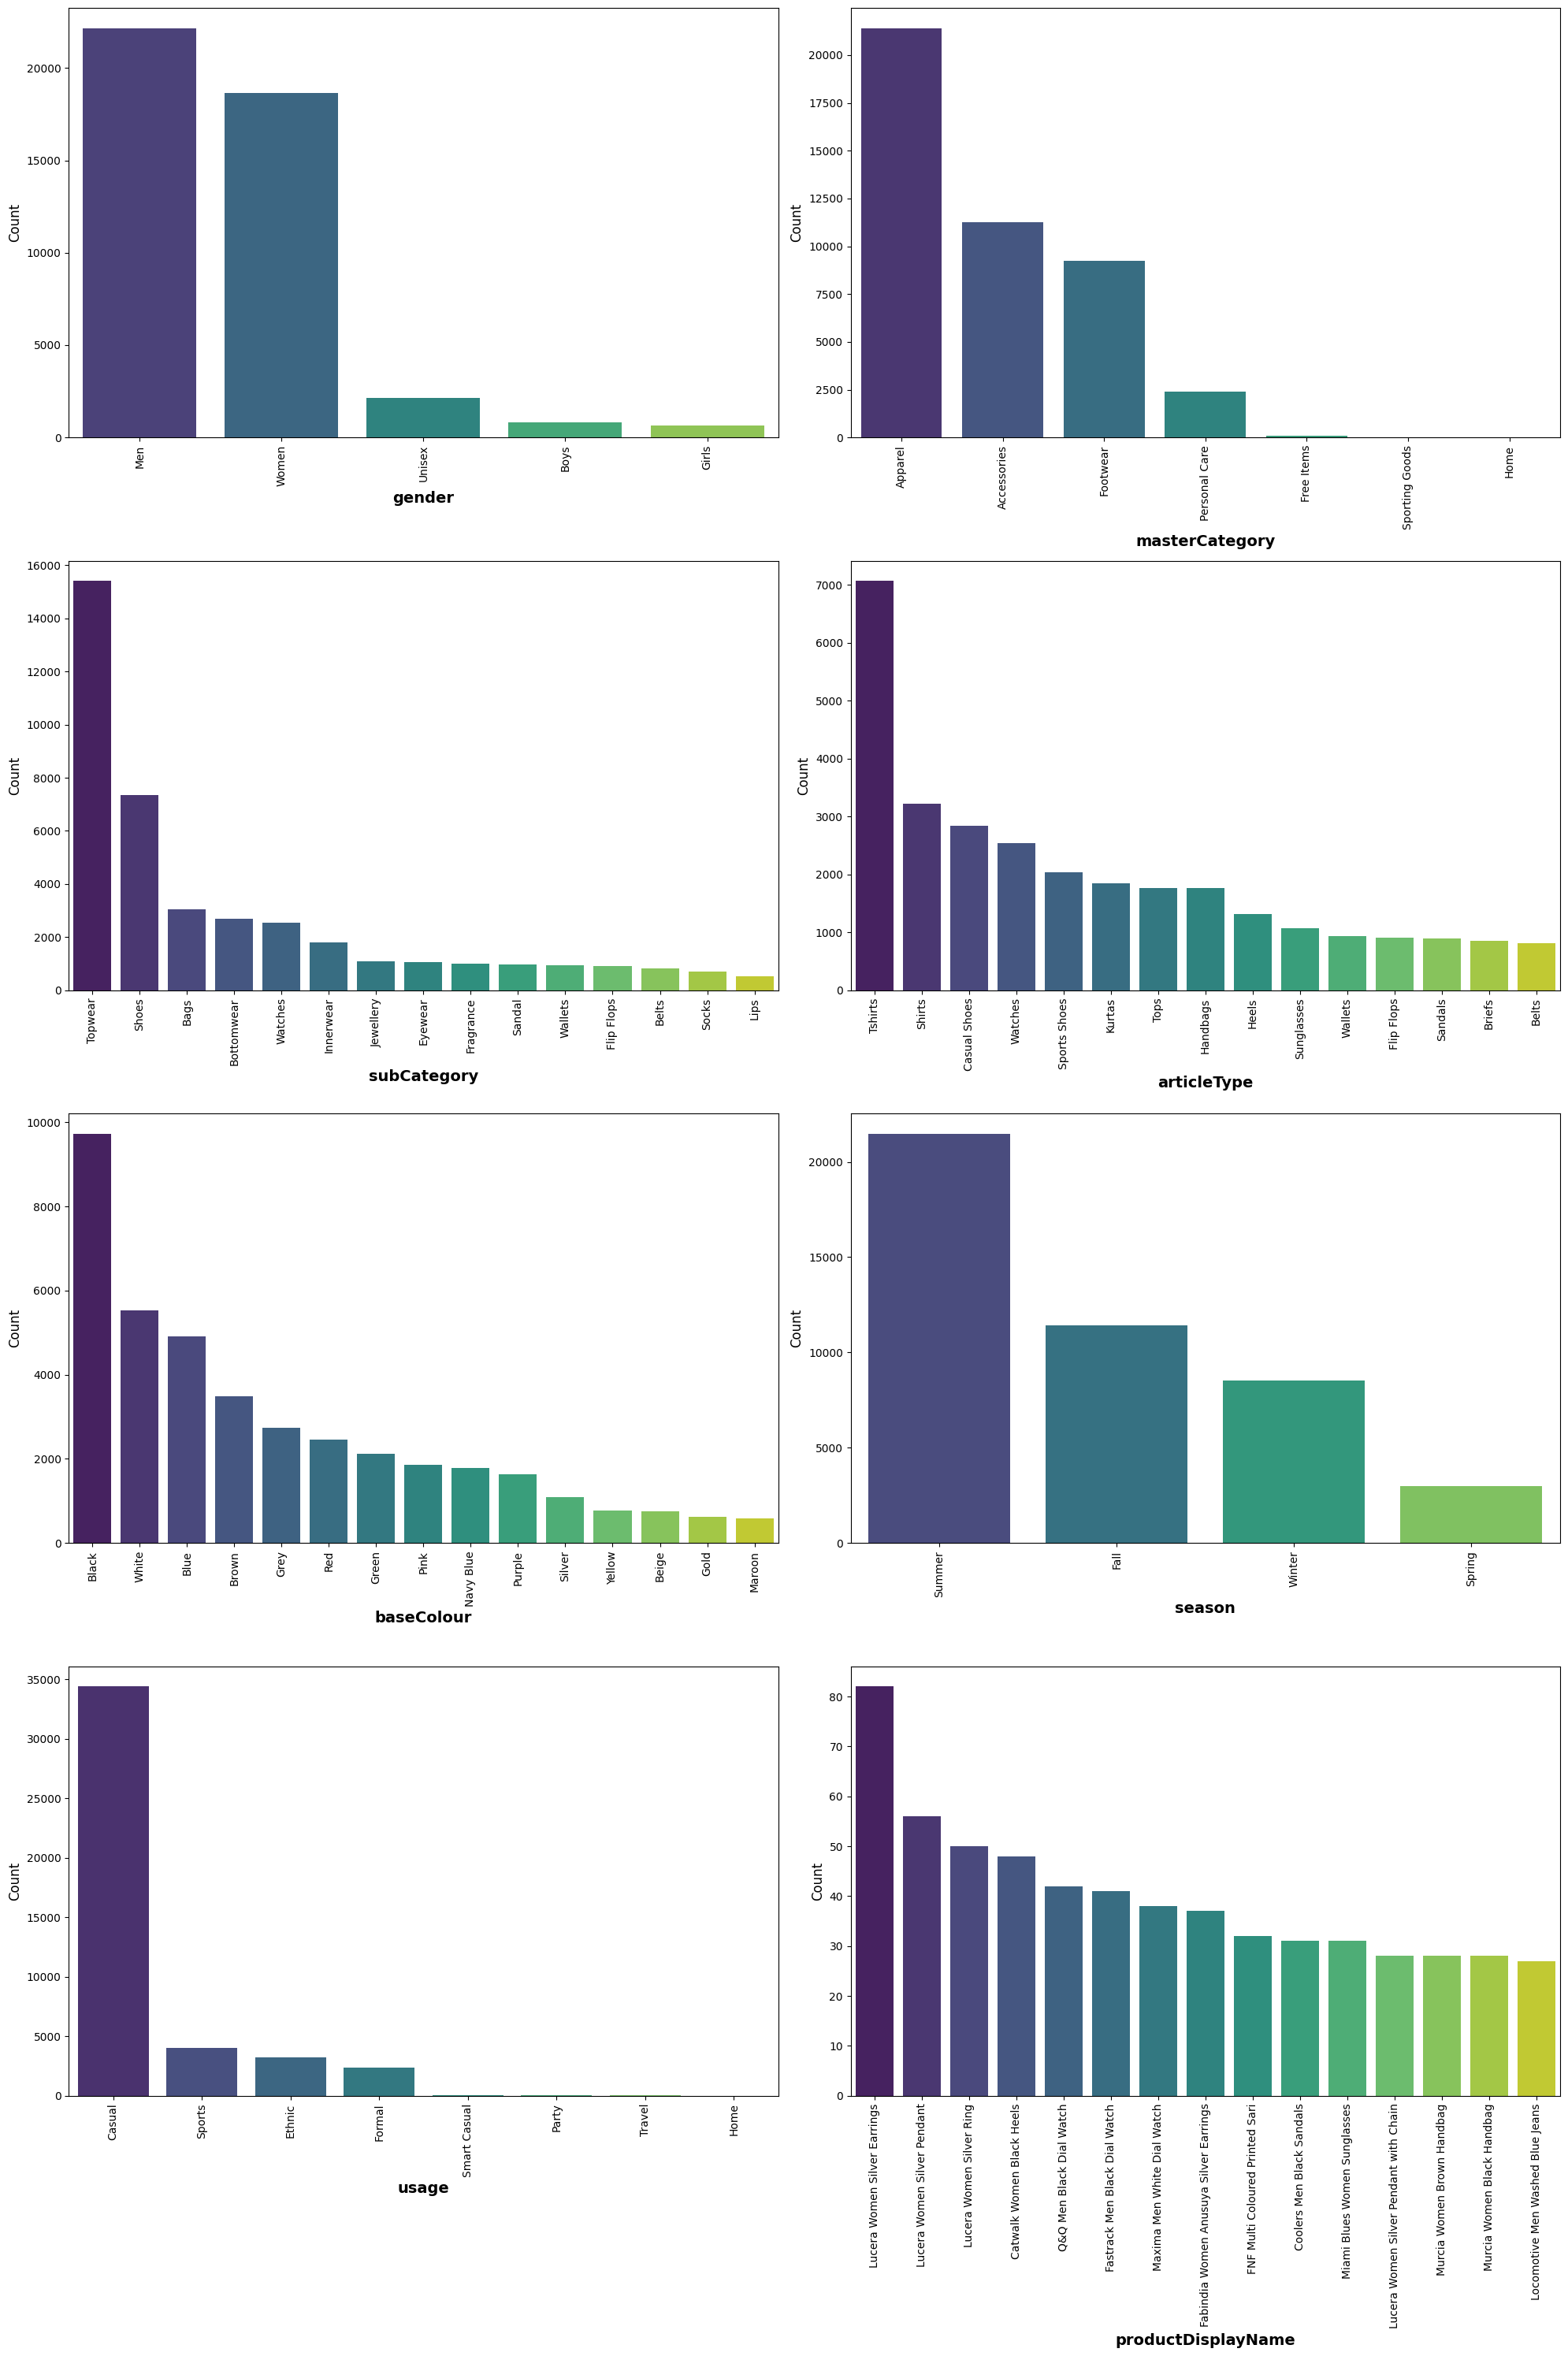

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 30))
ax = ax.flatten()

for i, col in enumerate(cols):
    if i != 8:
        value_counts = styles_df[col].value_counts().nlargest(15)
        sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax[i], palette="viridis")
        ax[i].set_xlabel(col, fontsize=14, fontweight='bold')
        ax[i].set_ylabel("Count", fontsize=12)
        ax[i].tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

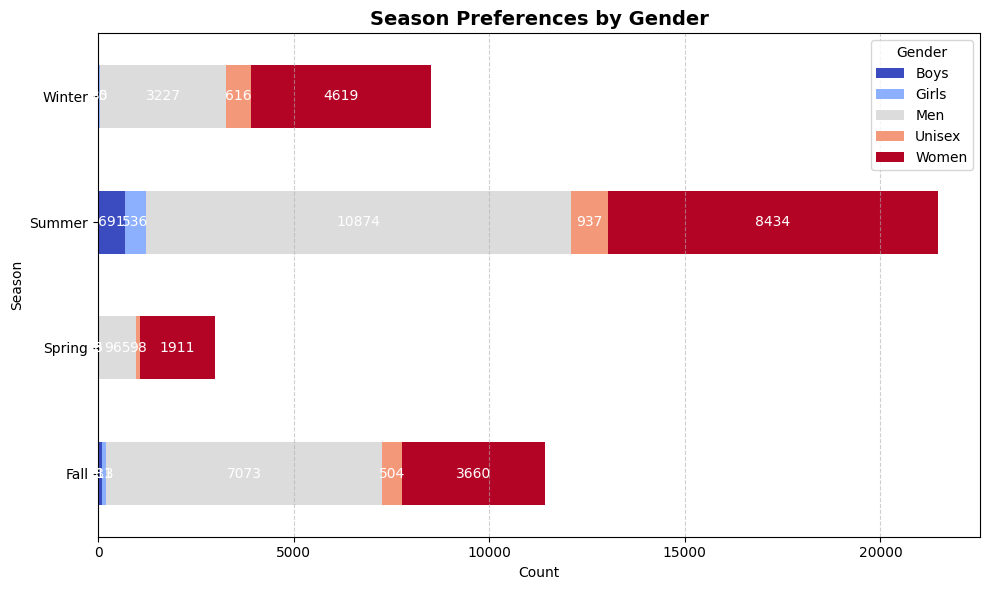

In [8]:

season_gender = pd.crosstab(styles_df['season'], styles_df['gender'])

plt.figure(figsize=(10, 6))
ax = season_gender.plot(kind='barh', stacked=True, colormap='coolwarm', figsize=(10, 6))

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='center', fontsize=10, color='white')

plt.title('Season Preferences by Gender', fontsize=14, fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Season')
plt.legend(title="Gender")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [16]:
# def plot_loss_curves(history):
   
#   loss = history.history['loss']
#   val_loss = history.history['val_loss']

#   accuracy = history.history['accuracy']
#   val_accuracy = history.history['val_accuracy']

#   epochs = range(len(history.history['loss']))

#   # Plot loss
#   plt.plot(epochs, loss, label='training_loss')
#   plt.plot(epochs, val_loss, label='val_loss')
#   plt.title('Loss')
#   plt.xlabel('Epochs')
#   plt.legend()

#   # Plot accuracy
#   plt.figure()
#   plt.plot(epochs, accuracy, label='training_accuracy')
#   plt.plot(epochs, val_accuracy, label='val_accuracy')
#   plt.title('Accuracy')
#   plt.xlabel('Epochs')
#   plt.legend();

In [17]:
import tensorflow as tf
import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import ResNet50V2,EfficientNetB4

In [20]:
def create_model(num_classes, weights='/kaggle/input/resnet-wtt/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5'):
    base_model = ResNet50V2(input_shape=(224, 224, 3), weights=weights, include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [21]:
def train_and_save_model(model, train_dataset, val_dataset, model_name):
    history = model.fit(
        train_dataset,
        epochs=3,
        steps_per_epoch=len(train_dataset),
        validation_data=val_dataset,
        validation_steps=len(val_dataset)
    )
    model.save_weights(f"{model_name}.weights.h5")
    model.save(f"{model_name}.keras")
    return history


In [22]:
def load_and_prep_image(filename, img_shape=224):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size=[img_shape, img_shape])
    return img / 255.0


In [23]:
def predict_and_plot(model, filename, class_names):
    img = load_and_prep_image(filename)
    pred = model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred.argmax()]
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
    plt.show()

In [24]:
def prepare_data(y_col):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
    train_dataset = datagen.flow_from_dataframe(styles_df, x_col='image', y_col=y_col, target_size=(224,224), batch_size=32, subset='training', class_mode='categorical')
    val_dataset = datagen.flow_from_dataframe(styles_df, x_col='image', y_col=y_col, target_size=(224,224), batch_size=32, subset='validation', class_mode='categorical')
    return train_dataset, val_dataset, list(train_dataset.class_indices.keys())


In [26]:
# Article Type Model
train_dataset, val_dataset, article_classes = prepare_data('articleType')
article_model = create_model(num_classes=len(article_classes))
train_and_save_model(article_model, train_dataset, val_dataset, "article_model")

Found 31094 validated image filenames belonging to 142 classes.
Found 13325 validated image filenames belonging to 142 classes.
Epoch 1/3
972/972 ━━━━━━━━━━━━━━━━━━━━ 1324s 1s/step - accuracy: 0.6542 - loss: 1.7445 - val_accuracy: 0.7808 - val_loss: 0.8231
Epoch 2/3
972/972 ━━━━━━━━━━━━━━━━━━━━ 0s 47us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/3
972/972 ━━━━━━━━━━━━━━━━━━━━ 955s 977ms/step - accuracy: 0.8395 - loss: 0.5700 - val_accuracy: 0.8065 - val_loss: 0.7776


In [27]:
# Gender Model
train_dataset, val_dataset, gender_classes = prepare_data('gender')
gender_model = create_model(num_classes=len(gender_classes))
train_and_save_model(gender_model, train_dataset, val_dataset, "gender_model")


Found 31094 validated image filenames belonging to 5 classes.
Found 13325 validated image filenames belonging to 5 classes.
Epoch 1/3
972/972 ━━━━━━━━━━━━━━━━━━━━ 948s 961ms/step - accuracy: 0.8066 - loss: 1.5446 - val_accuracy: 0.8801 - val_loss: 0.3517
Epoch 2/3
972/972 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/3
972/972 ━━━━━━━━━━━━━━━━━━━━ 941s 964ms/step - accuracy: 0.9104 - loss: 0.2662 - val_accuracy: 0.8844 - val_loss: 0.3401


In [35]:
# Season Model
train_dataset, val_dataset, season_classes = prepare_data('season')
season_model = create_model(num_classes=len(season_classes))
train_and_save_model(season_model, train_dataset, val_dataset, "season_model")


Found 31094 validated image filenames belonging to 5 classes.
Found 13325 validated image filenames belonging to 5 classes.
Epoch 1/3
972/972 ━━━━━━━━━━━━━━━━━━━━ 944s 957ms/step - accuracy: 0.6128 - loss: 1.6565 - val_accuracy: 0.6321 - val_loss: 0.8208
Epoch 2/3
972/972 ━━━━━━━━━━━━━━━━━━━━ 0s 55us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/3
972/972 ━━━━━━━━━━━━━━━━━━━━ 949s 972ms/step - accuracy: 0.7205 - loss: 0.6833 - val_accuracy: 0.7087 - val_loss: 0.7394


In [45]:
# Color Model
train_dataset, val_dataset, color_classes = prepare_data('baseColour')
color_model = create_model(num_classes=len(color_classes))
train_and_save_model(color_model, train_dataset, val_dataset, "color_model")


Found 31094 validated image filenames belonging to 47 classes.
Found 13325 validated image filenames belonging to 47 classes.
Epoch 1/3
972/972 ━━━━━━━━━━━━━━━━━━━━ 945s 957ms/step - accuracy: 0.2818 - loss: 3.3216 - val_accuracy: 0.4126 - val_loss: 2.1567
Epoch 2/3
972/972 ━━━━━━━━━━━━━━━━━━━━ 0s 52us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/3
972/972 ━━━━━━━━━━━━━━━━━━━━ 948s 971ms/step - accuracy: 0.4417 - loss: 1.9765 - val_accuracy: 0.4393 - val_loss: 2.0122


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


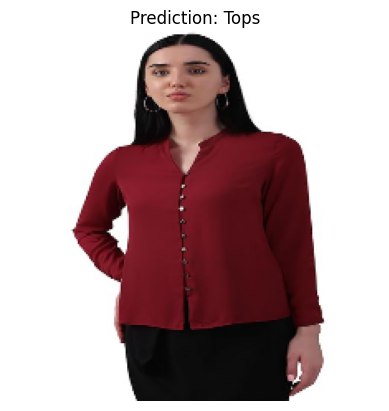

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


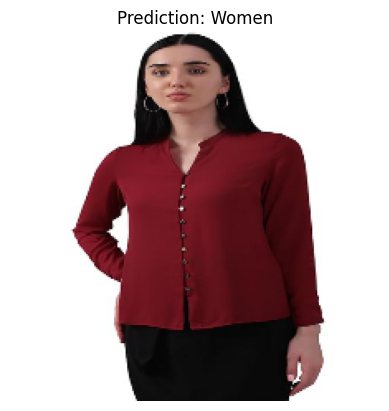

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


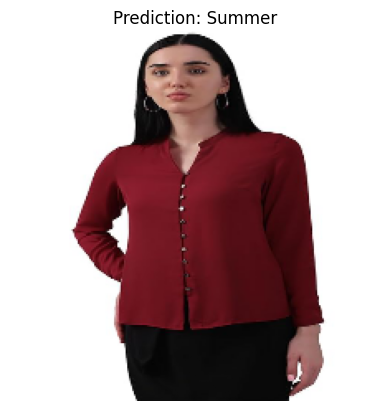

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


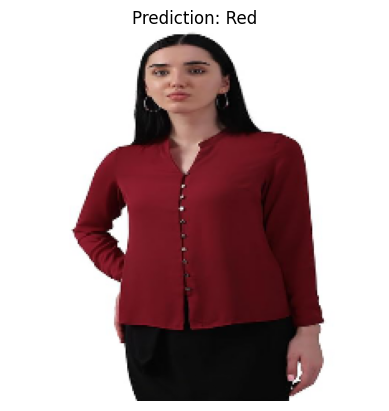

In [47]:
image_path = '/kaggle/input/screenshots-amazon/tshirt.png' 

models_classes = {
    article_model: article_classes,
    gender_model: gender_classes,
    season_model: season_classes,
    color_model: color_classes 
}

for model, classes in models_classes.items():
    predict_and_plot(model, image_path, classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


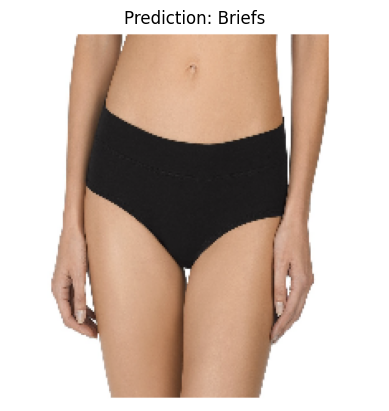

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


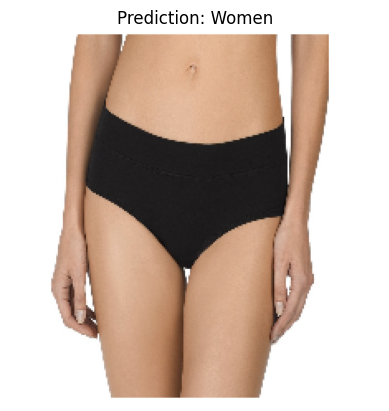

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


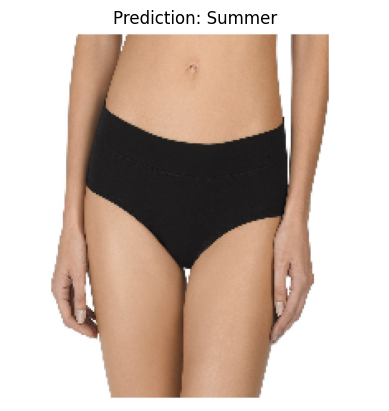

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


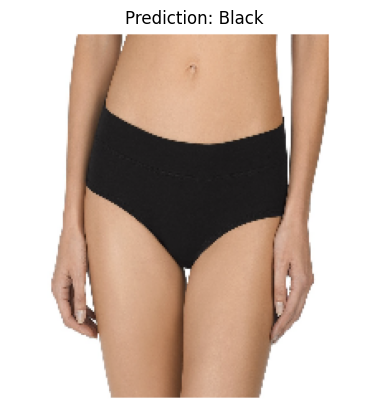

In [48]:
image_path = '/kaggle/input/screenshots-amazon/Screenshot 2023-04-17 at 11.26.20 AM.png' 

models_classes = {
    article_model: article_classes,
    gender_model: gender_classes,
    season_model: season_classes,
    color_model: color_classes 
}

for model, classes in models_classes.items():
    predict_and_plot(model, image_path, classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


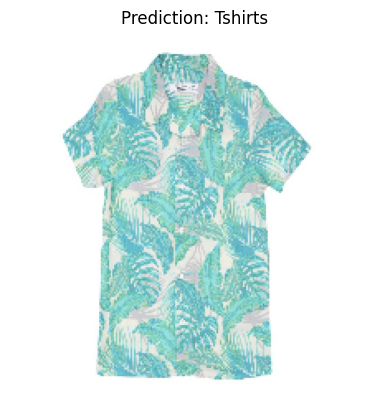

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


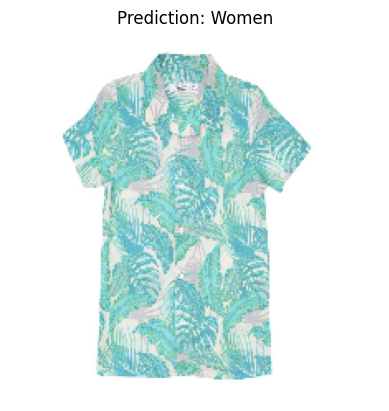

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


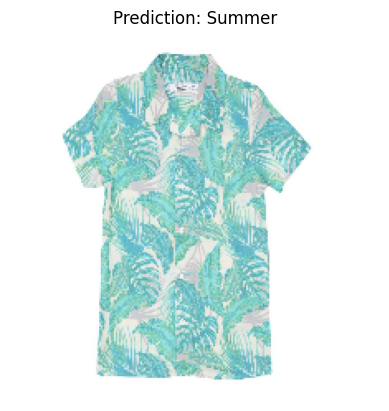

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


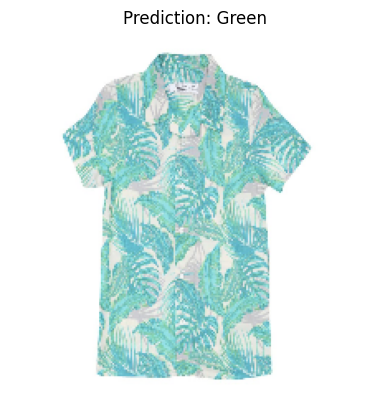

In [50]:
image_path = '/kaggle/input/screenshots-amazon/Screenshot 2023-04-17 at 11.28.20 AM.png' 

models_classes = {
    article_model: article_classes,
    gender_model: gender_classes,
    season_model: season_classes,
    color_model: color_classes 
}

for model, classes in models_classes.items():
    predict_and_plot(model, image_path, classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


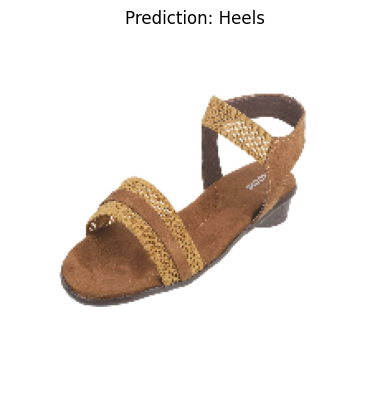

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


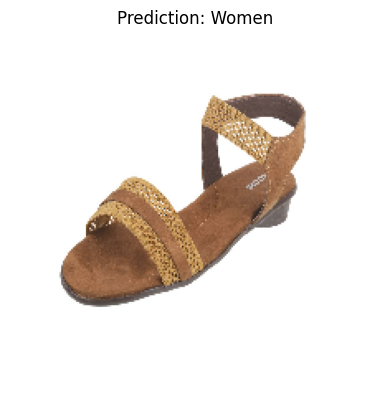

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


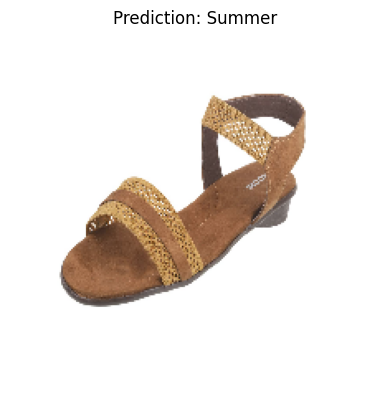

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


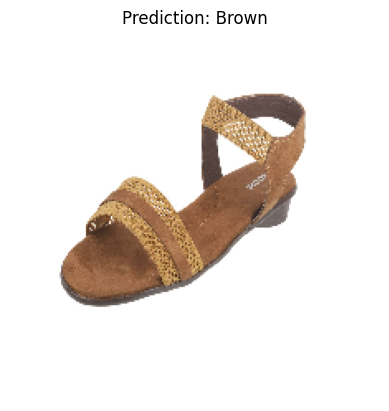

In [51]:
image_path = '/kaggle/input/screenshots-amazon/Screenshot 2023-04-17 at 11.29.23 AM.png' 

models_classes = {
    article_model: article_classes,
    gender_model: gender_classes,
    season_model: season_classes,
    color_model: color_classes 
}

for model, classes in models_classes.items():
    predict_and_plot(model, image_path, classes)
